In [1]:
import cv2
import dlib
import os
import numpy as np
import matplotlib.pyplot as plt
import openface
from facenet_pytorch import MTCNN
import create_directory

In [2]:
# hog face detector
hog_detector = dlib.get_frontal_face_detector()
# Download at: http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
predictor_model = os.path.join(create_directory.detection_preprocess_model_dir, "shape_predictor_68_face_landmarks.dat")
face_pose_predictor = dlib.shape_predictor(predictor_model)
# pip install git+https://github.com/cmusatyalab/openface.git
face_aligner = openface.AlignDlib(predictor_model)

# mtcnn face detector
mtcnn_detector = MTCNN(image_size=160, margin=0, min_face_size=20,
                       thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True)

# Ví dụ preprocess ảnh

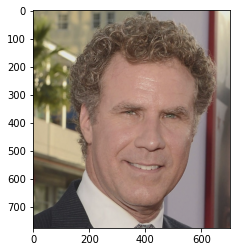

In [3]:
sample_path = os.path.join(create_directory.result_dir, "preprocess")
face_image = cv2.imread(os.path.join(sample_path, "test.png"))
face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)
plt.imshow(face_image)

## HOG + Aligned Face

In [4]:
detected_faces = hog_detector(face_image, 1)

In [5]:
def convert_and_trim_bb(image, rect):
    	# extract the starting and ending (x, y)-coordinates of the
	# bounding box (forming bigger boxes)
    startX = rect.left() - 50
    startY = rect.top() - 50
    endX = rect.right() + 50
    endY = rect.bottom() + 50
	# ensure the bounding box coordinates fall within the spatial
	# dimensions of the image
    startX = max(0, startX)
    startY = max(0, startY)
    endX = min(endX, image.shape[1])
    endY = min(endY, image.shape[0])
	# compute the width and height of the bounding box
    w = endX - startX
    h = endY - startY
    
    return (startX, startY, w, h)

box=[convert_and_trim_bb(face_image, r) for r in detected_faces]

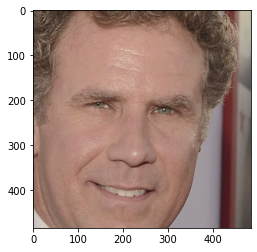

In [7]:
image = face_image[box[0][0]:box[0][0]+box[0][2], box[0][1]:box[0][1]+box[0][3]]
plt.imshow(image)

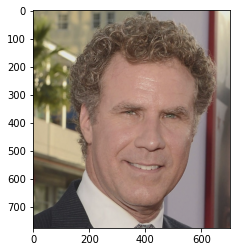

In [8]:
plt.imshow(face_image)

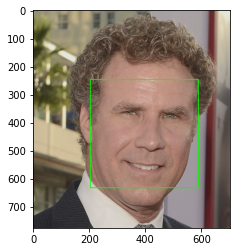

In [5]:
def convert_and_trim_bb(image, rect):
	startX = rect.left()
	startY = rect.top()
	endX = rect.right()
	endY = rect.bottom()

	return (startX, startY, endX, endY)
boxes = [convert_and_trim_bb(face_image, r) for r in detected_faces]
bounding_box = face_image.copy()
for (x, y, w, h) in boxes:
	cv2.rectangle(bounding_box, (x, y), (w, h), (0, 255, 0), 2)
plt.imshow(bounding_box)

In [6]:
# Phát hiện face landmarks
pose_landmarks = face_pose_predictor(face_image, detected_faces[0])
print("Số lượng face landmark: "+str(pose_landmarks.num_parts))
print("Toạ độ các điểm face landmark: ")
print(pose_landmarks.parts())

Số lượng face landmark: 68
Toạ độ các điểm face landmark: 
points[(215, 366), (213, 421), (212, 476), (219, 529), (237, 578), (267, 621), (303, 659), (346, 689), (394, 699), (441, 691), (476, 658), (508, 620), (535, 579), (552, 534), (561, 487), (568, 442), (575, 395), (279, 354), (307, 337), (341, 333), (376, 339), (408, 352), (451, 359), (483, 352), (513, 348), (542, 355), (556, 377), (429, 376), (428, 410), (427, 443), (426, 477), (380, 490), (398, 497), (418, 505), (437, 501), (453, 496), (320, 367), (339, 358), (359, 359), (373, 375), (355, 375), (336, 374), (463, 383), (481, 371), (501, 371), (517, 384), (501, 388), (482, 387), (323, 542), (358, 543), (389, 545), (409, 551), (429, 548), (450, 552), (469, 558), (446, 578), (424, 585), (404, 585), (382, 582), (353, 569), (334, 545), (388, 552), (408, 557), (428, 555), (459, 559), (426, 570), (406, 573), (385, 568)]


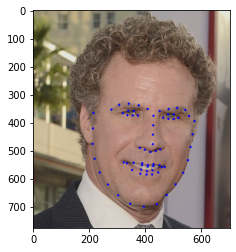

In [7]:
face_landmarks = face_image.copy()
for i in range(pose_landmarks.num_parts):
    cv2.circle(face_landmarks, (pose_landmarks.part(i).x,pose_landmarks.part(i).y), radius=4, color=(0, 0, 255), thickness=-1)
plt.imshow(face_landmarks)

In [8]:
help(face_aligner.align)

Help on method align in module openface.align_dlib:

align(imgDim, rgbImg, bb=None, landmarks=None, landmarkIndices=[39, 42, 57], skipMulti=False) method of openface.align_dlib.AlignDlib instance
    align(imgDim, rgbImg, bb=None, landmarks=None, landmarkIndices=INNER_EYES_AND_BOTTOM_LIP)
    
    Transform and align a face in an image.
    
    :param imgDim: The edge length in pixels of the square the image is resized to.
    :type imgDim: int
    :param rgbImg: RGB image to process. Shape: (height, width, 3)
    :type rgbImg: numpy.ndarray
    :param bb: Bounding box around the face to align. \
               Defaults to the largest face.
    :type bb: dlib.rectangle
    :param landmarks: Detected landmark locations. \
                      Landmarks found on `bb` if not provided.
    :type landmarks: list of (x,y) tuples
    :param landmarkIndices: The indices to transform to.
    :type landmarkIndices: list of ints
    :param skipMulti: Skip image if more than one face detected.
 

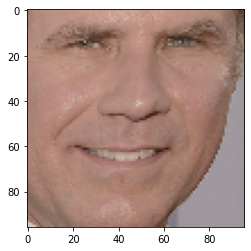

In [9]:
# Chỉnh sửa ảnh
alignedFace = face_aligner.align(imgDim = 96, rgbImg = face_image, 
                                 bb = detected_faces[0], landmarkIndices=openface.AlignDlib.OUTER_EYES_AND_NOSE)
plt.imshow(alignedFace)

In [10]:
alignedFace=cv2.cvtColor(alignedFace, cv2.COLOR_BGR2RGB)
cv2.imwrite(os.path.join(sample_path, "preprocess_img_hog.jpg"), alignedFace)

True

## MTCNN + aligned face

In [11]:
detected_faces = mtcnn_detector(face_image, 
                                save_path=os.path.join(sample_path, "preprocess_img_mtcnn.jpg"))

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


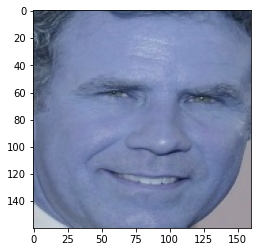

In [12]:
plt.imshow(cv2.imread(os.path.join(sample_path, "preprocess_img_mtcnn.jpg")))

# Lưu ảnh preprocess

In [13]:
# Path setting
source_path = os.path.join(create_directory.marvel_data_dir, "sample")
preprocess_path = os.path.join(create_directory.marvel_data_dir, "preprocess")
if not os.path.exists(preprocess_path):
    os.makedirs(preprocess_path)
preprocess_hog_path = os.path.join(preprocess_path, "hog")
preprocess_mtcnn_path = os.path.join(preprocess_path, "mtcnn")
if not os.path.exists(preprocess_hog_path):
    os.makedirs(preprocess_hog_path)
if not os.path.exists(preprocess_mtcnn_path):
    os.makedirs(preprocess_mtcnn_path)

In [20]:
# HOG
def hog_preprocess(image_path, save_path, upsample=3):
    try:
        image = cv2.imread(image_path)
        rects = hog_detector(image, upsample)
        if len(rects)==1:
            # pose_landmarks = face_pose_predictor(image, rects[0])
            alignedFace = face_aligner.align(imgDim = 96, rgbImg = image, bb = rects[0], 
                                            landmarkIndices=openface.AlignDlib.OUTER_EYES_AND_NOSE)
            cv2.imwrite(os.path.join(save_path, os.path.basename(image_path)), alignedFace)
    except:
        pass

# MTCNN
def mtcnn_preprocess(image_path, path):
    try:
        image = cv2.imread(image_path)
        rects, _ = mtcnn_detector.detect(image)
        if not rects is None:
            if rects.shape[0]==1:
                face_img = mtcnn_detector(image, save_path = os.path.join(path, os.path.basename(image_path)))
    except:
        pass

def process(source_path, save_path, preprocess_type):
    for i in os.listdir(source_path):
        if i==".DS_Store":
            continue
        print(i)
        image_source_path = os.path.join(source_path, i)
        for j in os.listdir(image_source_path):
            if j==".DS_Store":
                continue
            print("Image: "+j)
            if not os.path.exists(os.path.join(save_path, i)):
                os.mkdir(os.path.join(save_path, i))
            if preprocess_type=="hog":
                hog_preprocess(os.path.join(image_source_path, j), os.path.join(save_path, i))
            elif preprocess_type=="mtcnn":
                mtcnn_preprocess(os.path.join(image_source_path, j), os.path.join(save_path, i))

### HOG

In [15]:
process(source_path, preprocess_hog_path, preprocess_type="hog")

Robert Downey Jr
Image: Robert Downey Jr15_4151.jpg
Image: Robert Downey Jr51_4282.jpg
Image: Robert Downey Jr243_4256.jpg
Image: Robert Downey Jr122_4100.jpg
Image: Robert Downey Jr50_4281.jpg
Image: Robert Downey Jr105_4087.jpg
Image: Robert Downey Jr242_4255.jpg
Image: Robert Downey Jr118_4096.jpg
Image: Robert Downey Jr61_4288.jpg
Image: Robert Downey Jr119_4097.jpg
Image: Robert Downey Jr50_4280.jpg
Image: Robert Downey Jr42_4273.jpg
Image: Robert Downey Jr20_4192.jpg
Image: Robert Downey Jr85_4306.jpg
Image: Robert Downey Jr215_4206.jpg
Image: Robert Downey Jr221_4210.jpg
Image: Robert Downey Jr170_4167.jpg
Image: Robert Downey Jr234_4245.jpg
Image: Robert Downey Jr65_4292.jpg
Image: Robert Downey Jr167_4161.jpg
Image: Robert Downey Jr92_4314.jpg
Image: Robert Downey Jr93_4315.jpg
Image: Robert Downey Jr166_4160.jpg
Image: Robert Downey Jr221_4211.jpg
Image: Robert Downey Jr128_4105.jpg
Image: Robert Downey Jr99_4316.jpg
Image: Robert Downey Jr112_4091.jpg
Image: Robert Downey Jr

### MTCNN

In [16]:
process(source_path, preprocess_mtcnn_path, preprocess_type="mtcnn")

Robert Downey Jr
Image: Robert Downey Jr15_4151.jpg
Image: Robert Downey Jr51_4282.jpg
Image: Robert Downey Jr243_4256.jpg
Image: Robert Downey Jr122_4100.jpg
Image: Robert Downey Jr50_4281.jpg
Image: Robert Downey Jr105_4087.jpg
Image: Robert Downey Jr242_4255.jpg
Image: Robert Downey Jr118_4096.jpg
Image: Robert Downey Jr61_4288.jpg
Image: Robert Downey Jr119_4097.jpg
Image: Robert Downey Jr50_4280.jpg
Image: Robert Downey Jr42_4273.jpg
Image: Robert Downey Jr20_4192.jpg
Image: Robert Downey Jr85_4306.jpg
Image: Robert Downey Jr215_4206.jpg
Image: Robert Downey Jr221_4210.jpg
Image: Robert Downey Jr170_4167.jpg
Image: Robert Downey Jr234_4245.jpg
Image: Robert Downey Jr65_4292.jpg
Image: Robert Downey Jr167_4161.jpg
Image: Robert Downey Jr92_4314.jpg
Image: Robert Downey Jr93_4315.jpg
Image: Robert Downey Jr166_4160.jpg
Image: Robert Downey Jr221_4211.jpg
Image: Robert Downey Jr128_4105.jpg
Image: Robert Downey Jr99_4316.jpg
Image: Robert Downey Jr112_4091.jpg
Image: Robert Downey Jr